In [1]:

import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

import tensorflow.keras
import numpy as np
import tensorflow as tf


2024-04-16 17:37:22.452586: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-16 17:37:22.736609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-16 17:37:24.242132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
BINARY_SIZE = 2
PATCH_SIZE = 8
BATCH_SIZE = 256

In [3]:
def load_keras_dataset(dataset_name):
    import keras.datasets as datasets
    (x_train, _), (x_test, _) = getattr(datasets, dataset_name).load_data()

    x_train = np.append(x_train, x_test, axis=0)
    x_train = x_train.astype('float32') / 255.
    return x_train

def load_stl10():
    path = "data/stl10/train_X.bin"

    with open(path, 'rb') as f:
        data = np.fromfile(f, dtype=np.uint8)
        data = data.reshape(-1, 3, 96, 96)
        data = np.transpose(data, (0, 3, 2, 1))
        data = data.astype('float32') / 255.
    return data


def get_data():
    cifar10_dataset = load_keras_dataset('cifar10')
    cifar100_dataset = load_keras_dataset('cifar100')

    # append the datasets
    dataset = np.append(cifar10_dataset, cifar100_dataset, axis=0)
    
    return dataset

def get_validation_data():
    cifar100_dataset = load_keras_dataset('cifar100')[:500]

    return cifar100_dataset

def get_simple_data():
    cifar10_dataset = load_keras_dataset('cifar10')

    return cifar10_dataset

In [4]:
dataset = get_simple_data()
val_dataset = get_validation_data()

In [5]:
dataset.shape

(60000, 32, 32, 3)

In [6]:
# dataset to ycbcr
dataset = tf.image.rgb_to_yuv(dataset)
val_dataset = tf.image.rgb_to_yuv(val_dataset)

2024-04-16 12:40:55.401076: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 12:40:55.453380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 12:40:55.453416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 12:40:55.457123: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-16 12:40:55.457204: I tensorflow/compile

In [7]:
# tf.compat.v1.disable_eager_execution()
image_input = tensorflow.keras.layers.Input(shape=(None, None, 3))
x = tensorflow.keras.layers.Conv2D(32, (3, 3), padding='same')(image_input)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(64, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(128, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tensorflow.keras.layers.Conv2D(BINARY_SIZE, (3, 3), padding='same', activation='leaky_relu')(x)
encoded = tensorflow.keras.layers.MaxPooling2D((1, 1), padding='same')(x)

x = tensorflow.keras.layers.UpSampling2D((2, 2))(encoded)
x = tensorflow.keras.layers.Conv2DTranspose(128, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
x = tensorflow.keras.layers.Conv2DTranspose(64, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
x = tensorflow.keras.layers.UpSampling2D((2, 2))(x)
x = tensorflow.keras.layers.Conv2DTranspose(32, (3, 3), padding='same')(x)
x = tensorflow.keras.layers.LeakyReLU()(x)
decoded = tensorflow.keras.layers.Conv2DTranspose(3, (3, 3), padding='same')(x)

autoencoder = tensorflow.keras.Model(image_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()


autoencoder.fit(dataset, dataset, epochs=50, shuffle=True, batch_size=BATCH_SIZE, validation_data=(val_dataset, val_dataset))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, None, None, 32)    0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, None, None, 64)    0         
                                                             

2024-04-16 12:41:00.165636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2024-04-16 12:41:00.460614: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 12:41:01.938365: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x9c68b90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-16 12:41:01.938414: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-04-16 12:41:01.979587: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-16 12:41:02.254240: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-16 12:41:02.322788: I ./tensorflow/compiler/jit/de

235/235 [==============================] - 21s 63ms/step - loss: 0.0130 - val_loss: 0.0067
Epoch 2/50
235/235 [==============================] - 12s 52ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 3/50
235/235 [==============================] - 12s 52ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 4/50
235/235 [==============================] - 12s 52ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 5/50
235/235 [==============================] - 12s 53ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 6/50
235/235 [==============================] - 12s 52ms/step - loss: 0.0052 - val_loss: 0.0054
Epoch 7/50
235/235 [==============================] - 12s 52ms/step - loss: 0.0051 - val_loss: 0.0054
Epoch 8/50
235/235 [==============================] - 12s 52ms/step - loss: 0.0051 - val_loss: 0.0053
Epoch 9/50
235/235 [==============================] - 12s 52ms/step - loss: 0.0050 - val_loss: 0.0054
Epoch 10/50
235/235 [==============================] - 12s 51ms/step - loss: 0.0050 - val_los

In [8]:
def pad_image(image: np.ndarray, patch_size: int):
    h, w, c = image.shape
    h_pad = (patch_size - (h % patch_size)) % patch_size
    w_pad = (patch_size - (w % patch_size)) % patch_size

    return np.pad(image, ((0, h_pad), (0, w_pad), (0, 0)), mode='constant', constant_values=0), h_pad, w_pad

In [9]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')

image_copy = image
image = tf.image.rgb_to_yuv(image)
image, h, w  = pad_image(image, 8)
image = tf.expand_dims(image, axis=0)

reconstructed_image_32 = autoencoder.predict(image)

image = tf.image.yuv_to_rgb(image)
image = tf.cast(image * 255, tf.uint8)

reconstructed_image_32 = tf.image.yuv_to_rgb(reconstructed_image_32)
reconstructed_image_32 = tf.cast(reconstructed_image_32 * 255, tf.uint8)


1/1 [==============================] - 1s 916ms/step


In [10]:
# get rid of first dimension
image = tf.squeeze(image)
reconstructed_image_32 = tf.squeeze(reconstructed_image_32)

In [11]:
reconstructed_image_32 = reconstructed_image_32[:image_copy.shape[0], :image_copy.shape[1]]
image = image[:image_copy.shape[0], :image_copy.shape[1]]

print(image.shape)
print(reconstructed_image_32.shape)

(467, 396, 3)
(467, 396, 3)


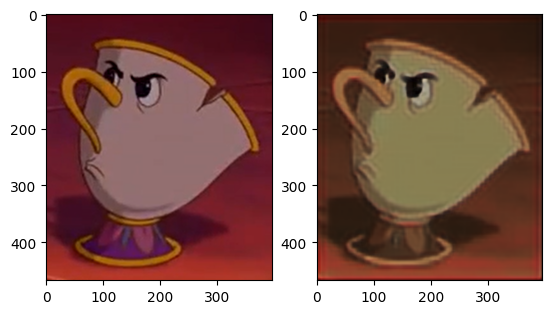

In [12]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_32)

In [13]:
# compute psnr
tf.image.psnr(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=22.511892>

In [14]:
tf.image.ssim(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8342893>

In [15]:
tf.image.ssim_multiscale(image, reconstructed_image_32, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.89166194>

In [16]:
encoder = tensorflow.keras.Model(image_input, encoded)

In [29]:
image = tf.image.decode_image(tf.io.read_file('ciob.png'), channels=3, dtype='float32')
image = tf.image.rgb_to_yuv(image)

image_, _, _ = pad_image(image, 8)

width = image_.shape[1]
height = image_.shape[0]

image_ = tf.expand_dims(image_, axis=0)

encoded_patches = encoder.predict(image_)

1/1 [==============================] - 0s 21ms/step


In [30]:
encoded_patches = encoded_patches.astype(np.float16)
copy_encoded_patches = encoded_patches.copy()

In [31]:
decoder_input = tensorflow.keras.layers.Input(shape=(None, None, BINARY_SIZE))
decoder = tensorflow.keras.Model(encoded, decoded)

rec = decoder.predict(encoded_patches)

1/1 [==============================] - 0s 77ms/step


In [32]:
rec.shape

(1, 472, 400, 3)

In [33]:
reconstructed_image_16 = tf.squeeze(rec)
reconstructed_image_16 = tf.image.yuv_to_rgb(reconstructed_image_16)

reconstructed_image_16 = reconstructed_image_16[:image.shape[0], :image.shape[1]]
reconstructed_image_16 = tf.convert_to_tensor(reconstructed_image_16)
reconstructed_image_16 = tf.cast(reconstructed_image_16 * 255, tf.uint8)

image = tf.image.yuv_to_rgb(image)
image = tf.cast(image * 255, tf.uint8)

In [34]:
print(image.shape)
print(reconstructed_image_16.shape)

(467, 396, 3)
(467, 396, 3)


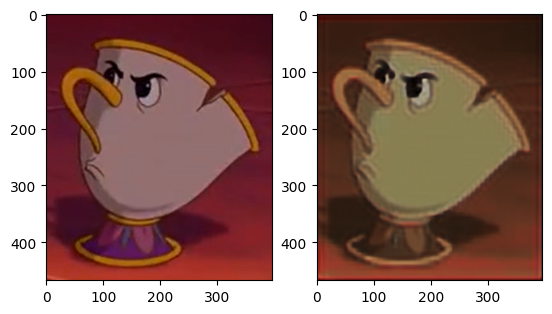

In [35]:
import matplotlib.pyplot as plt

ax, fig = plt.subplots(1, 2)
fig[0].imshow(image)
fig[1].imshow(reconstructed_image_16)

In [36]:
tf.image.psnr(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=22.512205>

In [37]:
tf.image.ssim(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.83428866>

In [38]:
tf.image.ssim_multiscale(image, reconstructed_image_16, max_val=255)

<tf.Tensor: shape=(), dtype=float32, numpy=0.8916573>

In [39]:
encoded_patches.shape

(1, 59, 50, 2)